In [88]:
import numpy as np
import pandas as pd

from mpl_toolkits.basemap import Basemap

import iris 
import iris.plot as iplt
import iris.quickplot as qplt

from mpl_toolkits.basemap import Basemap, maskoceans, shiftgrid 

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.gridspec as gridspec

import scipy
from scipy import stats

from numpy.fft import *
from scipy.ndimage import gaussian_filter

import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

In [89]:
def area_weighted(data_in):
 #call function to compute annuals mean from monthly means
    #data_in=compute_annual_nc(data_in) 
 
 #On a lat,long grid the grid-spacing reduces near the poles, we need to use area weights in our spatial mean to take into account
 #the irregularity of the grid. To compute the area-weighted spatial mean we get the area of each cell using cartography.area_weights.  
 #This uses the 'cell_area' attribute to calculate the area of each grid-box. 
    data_in.coord('latitude').guess_bounds()
    data_in.coord('longitude').guess_bounds()
    cell_area = iris.analysis.cartography.area_weights(data_in)

    data_out= data_in.collapsed(['latitude', 'longitude'],
                                 iris.analysis.MEAN,
                                  weights=cell_area)
 
    return(data_out)

In [91]:
def extract_AR(data_in):

    lat_min = 70
    lat_max = 90
    lon_min = 0
    lon_max = 360
    
    R=iris.Constraint(latitude=lambda  lat: lat_min <= lat <= lat_max, longitude= lambda lon: lon_min <= lon <= lon_max )  
    #Extract area 
    data_out=data_in.extract(R) 

    bmap=Basemap(projection= 'gall', llcrnrlat= lat_min,  urcrnrlat= lat_max, llcrnrlon= lon_min,  urcrnrlon= lon_max, resolution='l')
    lon= data_out.coord('longitude').points     
    lat= data_out.coord('latitude').points
    x,y=bmap(*np.meshgrid(lon,lat))
    contours=bmap.contourf(x,y, data_out[0,:,:].data, levels=80, cmap=matplotlib.cm.RdYlGn)
    bmap.drawcoastlines()
    #plt.figure(figsize=(16, 14))  # Adjust the values as per your requirement
     #plt.show()
     #'''
    return(data_out)

In [92]:

def compute_mean(data_in):
    """
    compute for the mean
    """
    i_sum = 0
    for i in range (0,len(data_in)):
        if np.isnan(data_in[i]):
            continue
        i_sum += data_in[i]
    mean = i_sum/(len(data_in)-np.isnan(data_in).sum())
    return mean

def compute_std(data_in, mean):
    """
    compute for std
    """
    i_std = 0
    for i in range (0, len(data_in)):
        if np.isnan(data_in[i]):
            continue
        i_std += (data_in[i] - mean)**2 
    std = np.sqrt(i_std/(len(data_in)-np.isnan(data_in).sum()-1))
    return std

def compute_annual(data_in):
    """
    Compute annual means from monthly means.
    """
    # Reshape the data to 12 months per year
    data_reshaped = data_in.reshape(-1, 12)
    # Compute the mean along the months axis
    annual_means = np.mean(data_reshaped, axis=1)
    return annual_means

def plot_tseries(data_in, label, linestyle, color, title):

    #data_in = TAS.data
    mean=compute_mean(data_in.data)
    stdev=compute_std(data_in.data, mean)
    
    times=np.arange(0,len(data_in),1)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(times, data_in)
    line_fit= slope*times + intercept
    #plt.plot(data_in)
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel(f'Precipitation ($m/s$)')
    plt.axhline(y=mean, c ='black', linestyle = ':') #, label=r'$\mu$')
    plt.plot(data_in, label=label)
    plt.plot(line_fit, c=color, linestyle=linestyle,linewidth=2)
    plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
    #Print p values and etc.
    print ('P_VALUE', p_value)
    print ('SLOPE', slope)
    print ('STD_ERR', std_err)
    print (' ')

In [93]:
pr1 = iris.load_cube('/scratch/lvillanu/data/pa-pdSIC-ext_pr_combined.nc')
print(pr1)

Large-scale (stable) precipitation rate (liq + ice) / (m/s) (time: 600; latitude: 96; longitude: 144)
    Dimension coordinates:
        time                                                     x              -              -
        latitude                                                 -              x              -
        longitude                                                -              -              x
    Cell methods:
        0                                                   time: mean
    Attributes:
        CDI                                                 'Climate Data Interface version 2.2.1 (https://mpimet.mpg.de/cdi)'
        CDO                                                 'Climate Data Operators version 2.2.0 (https://mpimet.mpg.de/cdo)'
        Conventions                                         'CF-1.0'
        NCO                                                 'netCDF Operators version 4.7.6 (Homepage = http://nco.sf.net, Code = h ...'
        Version

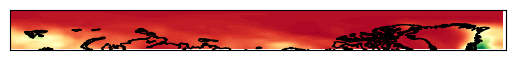

In [94]:
pr1_ = extract_AR(pr1)

In [95]:
#Compute area-weighted annual time series
pr1__ = area_weighted(pr1_)
print(pr1__)

Large-scale (stable) precipitation rate (liq + ice) / (m/s) (time: 600)
    Dimension coordinates:
        time                                                     x
    Scalar coordinates:
        latitude                                            80.05263157894737 degrees, bound=(70.10526315789474, 90.0) degrees
        longitude                                           178.75 degrees, bound=(-1.25, 358.75) degrees
    Cell methods:
        0                                                   time: mean
        1                                                   latitude: longitude: mean
    Attributes:
        CDI                                                 'Climate Data Interface version 2.2.1 (https://mpimet.mpg.de/cdi)'
        CDO                                                 'Climate Data Operators version 2.2.0 (https://mpimet.mpg.de/cdo)'
        Conventions                                         'CF-1.0'
        NCO                                                 'ne

P_VALUE 0.6125064094680814
SLOPE -3.537660166215492e-13
STD_ERR 6.980867065607631e-13
 


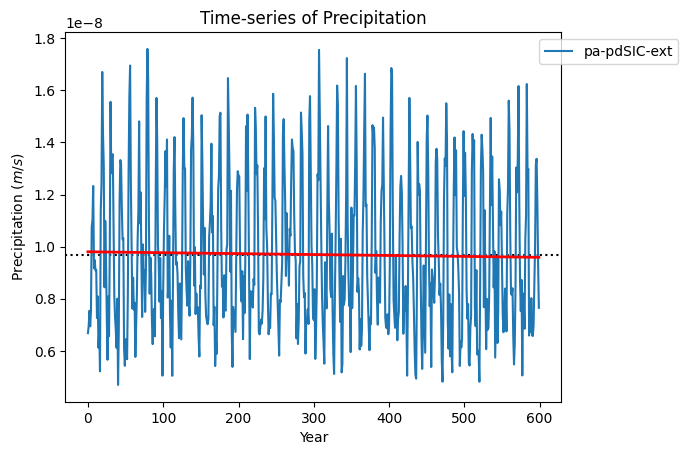

In [96]:
#Plot data with regression line and print out 'slope, std_err, p_value'

plot_tseries(pr1__.data, label='pa-pdSIC-ext', color='red',
             linestyle='-', title='Time-series of Precipitation')

In [97]:
pr1__a = compute_annual(pr1__.data)

In [98]:
pr1__a.data

array([8.88627172e-09, 1.00699123e-08, 1.01364528e-08, 9.17026151e-09,
       9.47354996e-09, 9.49658914e-09, 1.08579406e-08, 9.42376225e-09,
       9.83631127e-09, 9.37065517e-09, 9.75521111e-09, 1.04286704e-08,
       9.26771182e-09, 9.36855307e-09, 9.79993701e-09, 1.02832993e-08,
       9.39953601e-09, 9.84149766e-09, 1.01999962e-08, 9.33123530e-09,
       1.01322502e-08, 9.78448090e-09, 1.12843931e-08, 9.66230036e-09,
       9.44417585e-09, 1.04162109e-08, 9.09300023e-09, 9.92709893e-09,
       9.32277934e-09, 1.03468346e-08, 1.00162182e-08, 1.01262782e-08,
       1.00311006e-08, 9.88359580e-09, 9.08952199e-09, 9.70576645e-09,
       8.89675624e-09, 9.42480467e-09, 9.72512369e-09, 9.59649320e-09,
       9.50156185e-09, 9.44747879e-09, 9.13127081e-09, 9.43475310e-09,
       9.61175765e-09, 9.20345990e-09, 9.82300679e-09, 9.81098299e-09,
       9.53660093e-09, 9.05801614e-09])

P_VALUE 0.2009986975796539
SLOPE -6.1385001495913706e-12
STD_ERR 4.73463650421265e-12
 


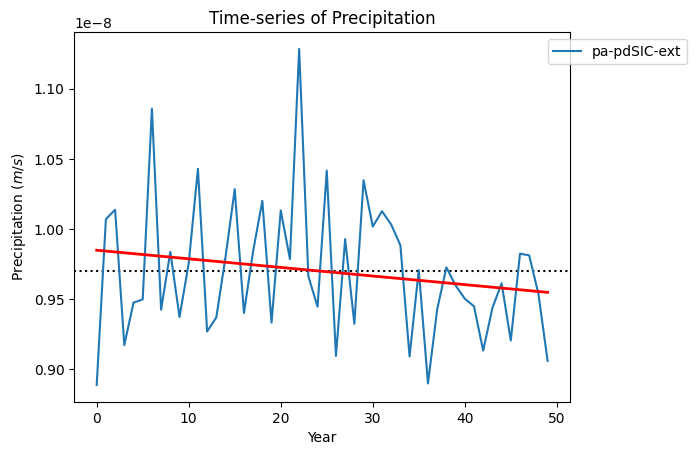

In [99]:
#Plot data with regression line and print out 'slope, std_err, p_value'

plot_tseries(pr1__a.data, label='pa-pdSIC-ext', color='red',
             linestyle='-', title='Time-series of Precipitation')

In [100]:
pr2 = iris.load_cube('/scratch/lvillanu/data/pa-futArcSIC-ext_pr_combined.nc')
print(pr2)

Large-scale (stable) precipitation rate (liq + ice) / (m/s) (time: 600; latitude: 96; longitude: 144)
    Dimension coordinates:
        time                                                     x              -              -
        latitude                                                 -              x              -
        longitude                                                -              -              x
    Cell methods:
        0                                                   time: mean
    Attributes:
        CDI                                                 'Climate Data Interface version 2.2.1 (https://mpimet.mpg.de/cdi)'
        CDO                                                 'Climate Data Operators version 2.2.0 (https://mpimet.mpg.de/cdo)'
        Conventions                                         'CF-1.0'
        NCO                                                 'netCDF Operators version 4.7.6 (Homepage = http://nco.sf.net, Code = h ...'
        Version

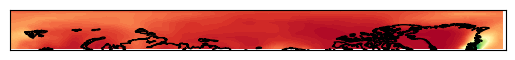

In [101]:
pr2_ = extract_AR(pr2)

In [102]:
#Compute area-weighted annual time series
pr2__ = area_weighted(pr2_)
print(pr2__)

Large-scale (stable) precipitation rate (liq + ice) / (m/s) (time: 600)
    Dimension coordinates:
        time                                                     x
    Scalar coordinates:
        latitude                                            80.05263157894737 degrees, bound=(70.10526315789474, 90.0) degrees
        longitude                                           178.75 degrees, bound=(-1.25, 358.75) degrees
    Cell methods:
        0                                                   time: mean
        1                                                   latitude: longitude: mean
    Attributes:
        CDI                                                 'Climate Data Interface version 2.2.1 (https://mpimet.mpg.de/cdi)'
        CDO                                                 'Climate Data Operators version 2.2.0 (https://mpimet.mpg.de/cdo)'
        Conventions                                         'CF-1.0'
        NCO                                                 'ne

P_VALUE 0.549406241268569
SLOPE 4.5383897037782897e-13
STD_ERR 7.576734162788388e-13
 


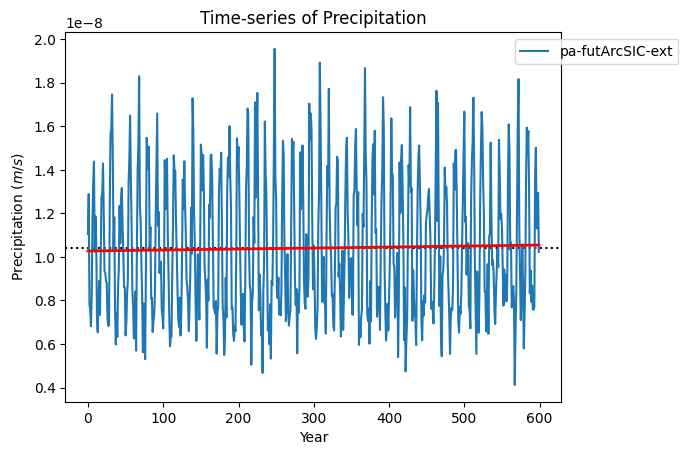

In [103]:
#Plot data with regression line and print out 'slope, std_err, p_value'

plot_tseries(pr2__.data, label='pa-futArcSIC-ext', color='red',
             linestyle='-', title='Time-series of Precipitation')

In [104]:
pr2__a = compute_annual(pr2__.data)

P_VALUE 0.2009986975796539
SLOPE -6.1385001495913706e-12
STD_ERR 4.73463650421265e-12
 
P_VALUE 0.5125587483209926
SLOPE 3.0456019996907498e-12
STD_ERR 4.616199767821286e-12
 
P_VALUE 0.2668733706052774
SLOPE 7.144104706119789e-12
STD_ERR 6.359606640404e-12
 


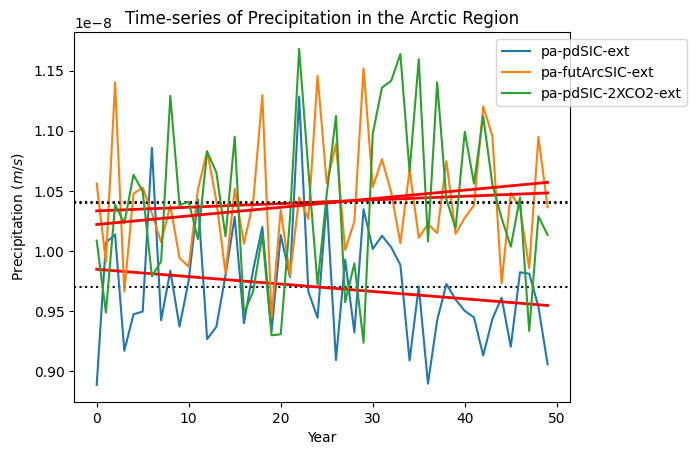

In [121]:
#Plot data with regression line and print out 'slope, std_err, p_value'

plot_tseries(pr1__a.data, label='pa-pdSIC-ext', color='red',
             linestyle='-', title='Time-series of Precipitation in the Arctic Region')

#Plot data with regression line and print out 'slope, std_err, p_value'

plot_tseries(pr2__a.data, label='pa-futArcSIC-ext', color='red',
             linestyle='-', title='Time-series of Precipitation in the Arctic Region')

plot_tseries(pr3__a.data, label='pa-pdSIC-2XCO2-ext', color='red',
             linestyle='-', title='Time-series of Precipitation in the Arctic Region')

In [106]:
# Ensure both cubes have the same units
if pr1.units != pr2.units:
    pr2.convert_units(pr1.units)

In [107]:
# Interpolate cube2 to match the time coordinates of cube1
time_coord = pr1.coord('time')
cube2_interp = pr2.interpolate([(time_coord, np.array(time_coord.points))], iris.analysis.Linear())

In [108]:
dpr1.data = pr2.data - pr1.data

In [109]:
dpr1

<iris 'Cube' of unknown / (m/s) (time: 600; latitude: 96; longitude: 144)>

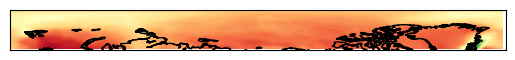

In [110]:
dpr1_ = extract_AR(dpr1)

In [111]:
#Compute area-weighted annual time series
dpr1__ = area_weighted(dpr1_)
print(dpr1__)

unknown / (m/s)                     (time: 600)
    Dimension coordinates:
        time                             x
    Scalar coordinates:
        latitude                    80.05263157894737 degrees, bound=(70.10526315789474, 90.0) degrees
        longitude                   178.75 degrees, bound=(-1.25, 358.75) degrees
    Cell methods:
        0                           latitude: longitude: mean
    Attributes:
        CDI                         'Climate Data Interface version 2.2.1 (https://mpimet.mpg.de/cdi)'
        CDO                         'Climate Data Operators version 2.2.0 (https://mpimet.mpg.de/cdo)'
        Conventions                 'CF-1.0'
        NCO                         'netCDF Operators version 4.7.6 (Homepage = http://nco.sf.net, Code = h ...'
        Version                     '$Name$'
        initial_file                '/scratch/p/pjk/aaudette/cesm1_2_2/inputdata/atm/waccm/ic/f2000.e10r02. ...'
        logname                     'aaudette'
        

P_VALUE 0.09311902116358518
SLOPE 8.076049891175255e-13
STD_ERR 4.801870172393681e-13
 


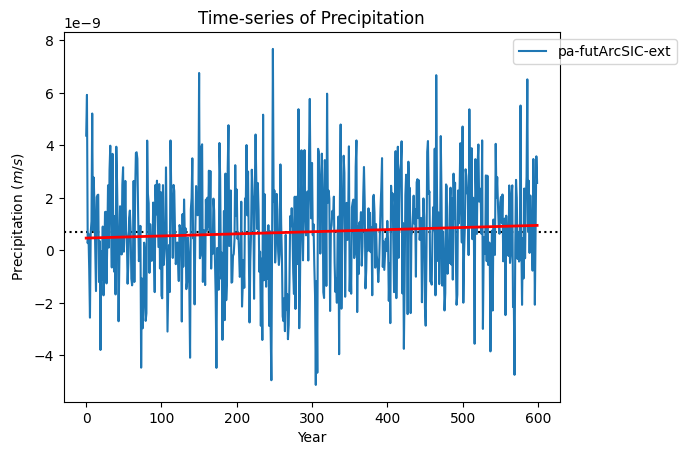

In [112]:
#Plot data with regression line and print out 'slope, std_err, p_value'

plot_tseries(dpr1__.data, label='pa-futArcSIC-ext', color='red',
             linestyle='-', title='Time-series of Precipitation')

In [113]:
dpr1__a = compute_annual(dpr1__.data)

P_VALUE 0.14406421421967577
SLOPE 9.184102175202812e-12
STD_ERR 6.184298888540092e-12
 


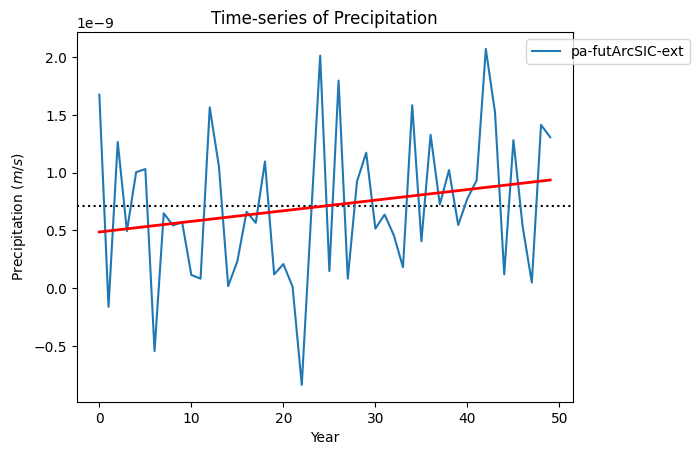

In [114]:
#Plot data with regression line and print out 'slope, std_err, p_value'

plot_tseries(dpr1__a.data, label='pa-futArcSIC-ext', color='red',
             linestyle='-', title='Time-series of Precipitation')

In [115]:
pr3 = iris.load_cube('/scratch/lvillanu/data/pa-pdSIC-2XCO2-ext_pr_combined.nc')
print(pr3)

Large-scale (stable) precipitation rate (liq + ice) / (m/s) (time: 600; latitude: 96; longitude: 144)
    Dimension coordinates:
        time                                                     x              -              -
        latitude                                                 -              x              -
        longitude                                                -              -              x
    Cell methods:
        0                                                   time: mean
    Attributes:
        CDI                                                 'Climate Data Interface version 2.2.1 (https://mpimet.mpg.de/cdi)'
        CDO                                                 'Climate Data Operators version 2.2.0 (https://mpimet.mpg.de/cdo)'
        Conventions                                         'CF-1.0'
        NCO                                                 'netCDF Operators version 4.7.6 (Homepage = http://nco.sf.net, Code = h ...'
        Version

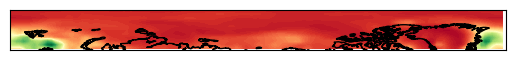

In [116]:
pr3_ = extract_AR(pr3)

In [117]:
#Compute area-weighted annual time series
pr3__ = area_weighted(pr3_)
print(pr3__)

Large-scale (stable) precipitation rate (liq + ice) / (m/s) (time: 600)
    Dimension coordinates:
        time                                                     x
    Scalar coordinates:
        latitude                                            80.05263157894737 degrees, bound=(70.10526315789474, 90.0) degrees
        longitude                                           178.75 degrees, bound=(-1.25, 358.75) degrees
    Cell methods:
        0                                                   time: mean
        1                                                   latitude: longitude: mean
    Attributes:
        CDI                                                 'Climate Data Interface version 2.2.1 (https://mpimet.mpg.de/cdi)'
        CDO                                                 'Climate Data Operators version 2.2.0 (https://mpimet.mpg.de/cdo)'
        Conventions                                         'CF-1.0'
        NCO                                                 'ne

P_VALUE 0.3322383541650731
SLOPE 7.726162871001714e-13
STD_ERR 7.961814678825086e-13
 


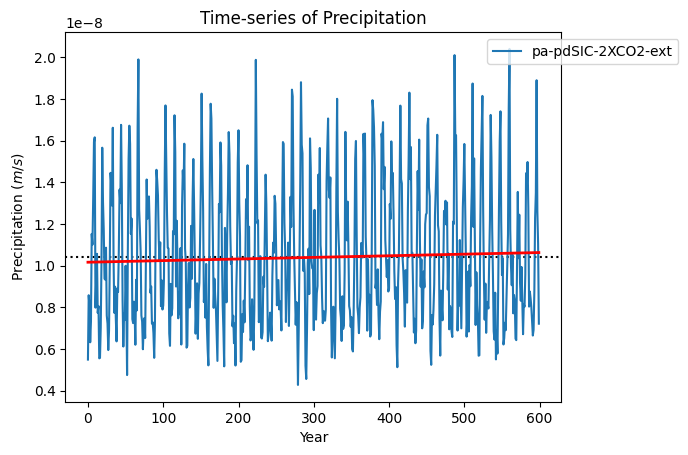

In [118]:
#Plot data with regression line and print out 'slope, std_err, p_value'

plot_tseries(pr3__.data, label='pa-pdSIC-2XCO2-ext', color='red',
             linestyle='-', title='Time-series of Precipitation')

In [119]:
pr3__a = compute_annual(pr3__.data)

P_VALUE 0.2668733706052774
SLOPE 7.144104706119789e-12
STD_ERR 6.359606640404e-12
 


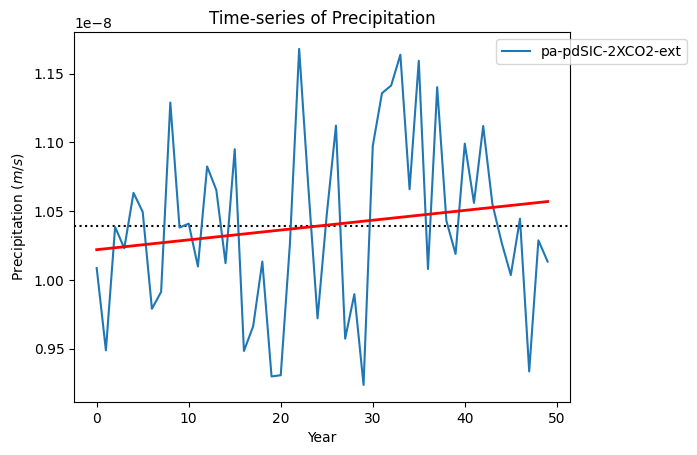

In [120]:
#Plot data with regression line and print out 'slope, std_err, p_value'

plot_tseries(pr3__a.data, label='pa-pdSIC-2XCO2-ext', color='red',
             linestyle='-', title='Time-series of Precipitation')